#Fake News Detection using Bi-Directional LSTM & Attention 

**IMPORT LIBRARIES**

In [ ]:
from importlib import reload
import sys
import warnings
warnings.filterwarnings('ignore')

  
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
  
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**LOAD DATA**

In [ ]:
import pandas as pd
  
df = pd.read_csv('/content/drive/My Drive/FakeNews Detection/Models & Dataset/Fake_or_real_news.csv', usecols=["title","text","label"])
df.head()

,title,text,label
0,You Can Smell Hillarys Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52786 entries, 0 to 52785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   52104 non-null  object
 1   text    51869 non-null  object
 2   label   51653 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.head()

,title,text,label
0,You Can Smell Hillarys Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.dropna(inplace=True)
df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
  
def clean_text(text):
	text = re.sub(r'[^\w\s]','',text, re.UNICODE)
	text = text.lower()
	text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
	text = [lemmatizer.lemmatize(token, "v") for token in text]
	text = [word for word in text if  not word in stop_words]
	text = " ".join(text)
	return text

title_text = df['title'] + " " + df['text']
df['Processed_Text'] = title_text.apply(lambda x: clean_text(x))
df.head()

,title,text,label,Processed_Text
0,You Can Smell Hillarys Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,smell hillary fear daniel greenfield shillman ...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch exact moment paul ryan commit political ...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerry go paris gesture sympathy u secretary st...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,bernie supporter twitter erupt anger dnc try w...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,battle new york primary matter primary day new...


In [ ]:
df['Processed_Text'][0]

'smell hillary fear daniel greenfield shillman journalism fellow freedom center new york writer focus radical islam \nin final stretch election hillary rodham clinton ha go war fbi \nthe word unprecedented ha throw around often election ought retire still unprecedented nominee major political party go war fbi \nbut thats exactly hillary people coma patient wake watch hour cnn hospital bed would assume fbi director jam comey hillary opponent election \nthe fbi attack everyone obama cnn hillary people circulate letter attack comey currently medium hit piece lambast target trump wouldnt surprise clinton ally start run attack ad fbi \nthe fbi leadership warn entire leftwing establishment form lynch mob continue go hillary fbi credibility attack medium democrat preemptively head result investigation clinton foundation hillary clinton \nthe covert struggle fbi agent obamas doj people ha go explosively public \nthe new york time ha compare comey j edgar hoover bizarre headline jam comey role 

In [ ]:
df.Processed_Text.apply(lambda x: len(x.split(" "))).mean()

280.6957195217733

In [ ]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Processed_Text'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Text'])
  
RNN_CELL_SIZE = 32
  
MAX_LEN = 281  # Since our mean length is 280.69
X = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y = (df.label.values=='REAL').astype('int')
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

**ATTENTION LAYER CLASS**

In [ ]:
class Attention(tf.keras.Model):
	def __init__(self, units):
		super(Attention, self).__init__()
		self.W1 = tf.keras.layers.Dense(units)
		self.W2 = tf.keras.layers.Dense(units)
		self.V = tf.keras.layers.Dense(1)

	def call(self, features, hidden):
		# hidden shape == (batch_size, hidden size)
		# hidden_with_time_axis shape == (batch_size, 1, hidden size)
		# we are doing this to perform addition to calculate the score
		hidden_with_time_axis = tf.expand_dims(hidden, 1)
		  
		# score shape == (batch_size, max_length, 1)
		# we get 1 at the last axis because we are applying score to self.V
		# the shape of the tensor before applying self.V is (batch_size, max_length, units)
		score = tf.nn.tanh(
			self.W1(features) + self.W2(hidden_with_time_axis))
		# attention_weights shape == (batch_size, max_length, 1)
		attention_weights = tf.nn.softmax(self.V(score), axis=1)
		  
		# context_vector shape after sum == (batch_size, hidden_size)
		context_vector = attention_weights * features
		context_vector = tf.reduce_sum(context_vector, axis=1)
		return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

**BI-DIRECTIONAL LSTM**

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h) #Attention Layer
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = tf.keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
# summarize layers
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 281)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 281, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 281, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 281, 64), (N 24832       bi_lstm_0[0][0]                  
_______________________________________________________________________________________

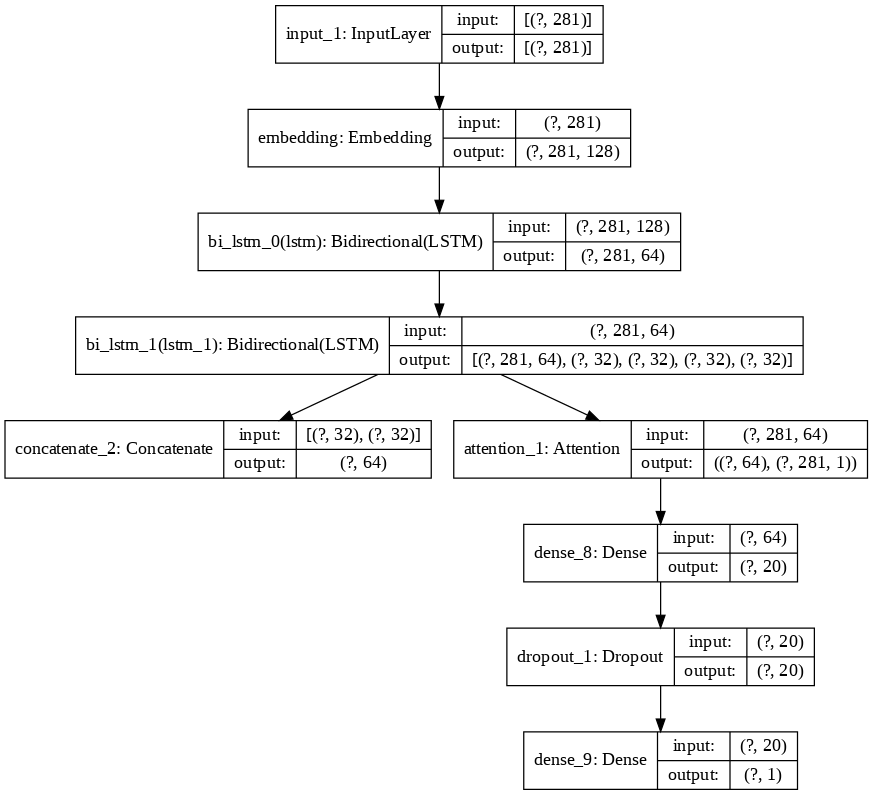

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [ ]:
METRICS = [
	keras.metrics.TruePositives(name='tp'),
	keras.metrics.FalsePositives(name='fp'),
	keras.metrics.TrueNegatives(name='tn'),
	keras.metrics.FalseNegatives(name='fn'),
	keras.metrics.BinaryAccuracy(name='accuracy'),
	keras.metrics.Precision(name='precision'),
	keras.metrics.Recall(name='recall'),
	keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

**TRAIN MODEL**

In [ ]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
					batch_size=BATCH_SIZE,
					epochs=EPOCHS,
					validation_data=(X_val, y_val))

Epoch 1/5
367/367 [==============================] - 27s 74ms/step - loss: 0.1955 - tp: 18328.0000 - fp: 1607.0000 - tn: 15578.0000 - fn: 1155.0000 - accuracy: 0.9247 - precision: 0.9194 - recall: 0.9407 - auc: 0.9760 - val_loss: 0.0904 - val_tp: 2323.0000 - val_fp: 52.0000 - val_tn: 2115.0000 - val_fn: 94.0000 - val_accuracy: 0.9682 - val_precision: 0.9781 - val_recall: 0.9611 - val_auc: 0.9944
Epoch 2/5
367/367 [==============================] - 25s 68ms/step - loss: 0.0614 - tp: 19088.0000 - fp: 383.0000 - tn: 16802.0000 - fn: 395.0000 - accuracy: 0.9788 - precision: 0.9803 - recall: 0.9797 - auc: 0.9970 - val_loss: 0.0818 - val_tp: 2305.0000 - val_fp: 36.0000 - val_tn: 2131.0000 - val_fn: 112.0000 - val_accuracy: 0.9677 - val_precision: 0.9846 - val_recall: 0.9537 - val_auc: 0.9958
Epoch 3/5
367/367 [==============================] - 25s 68ms/step - loss: 0.0317 - tp: 19296.0000 - fp: 175.0000 - tn: 17010.0000 - fn: 187.0000 - accuracy: 0.9901 - precision: 0.9910 - recall: 0.9904 -

In [ ]:
## Making predictions on our model
model.evaluate(X_test,y_test)

144/144 [==============================] - 4s 25ms/step - loss: 0.0949 - tp: 2399.0000 - fp: 52.0000 - tn: 2087.0000 - fn: 46.0000 - accuracy: 0.9786 - precision: 0.9788 - recall: 0.9812 - auc: 0.9919


[0.094905324280262,
 2399.0,
 52.0,
 2087.0,
 46.0,
 0.9786213040351868,
 0.9787841439247131,
 0.9811860918998718,
 0.9918543696403503]

In [ ]:
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)

**CONFUSION MATRIX**

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2139
           1       0.98      0.98      0.98      2445

    accuracy                           0.98      4584
   macro avg       0.98      0.98      0.98      4584
weighted avg       0.98      0.98      0.98      4584



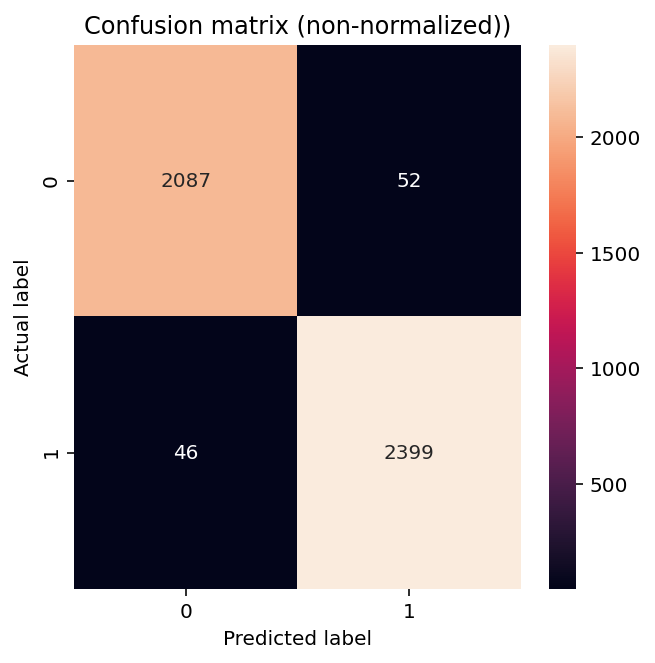

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
							 confusion_matrix,
							 roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, y_pred)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
	cm = confusion_matrix(labels, predictions)
	plt.figure(figsize=(5, 5))
	sns.heatmap(cm, annot=True, fmt="d")
	plt.title("Confusion matrix (non-normalized))")
	plt.ylabel("Actual label")
	plt.xlabel("Predicted label")
  
plot_cm(y_test, y_pred)

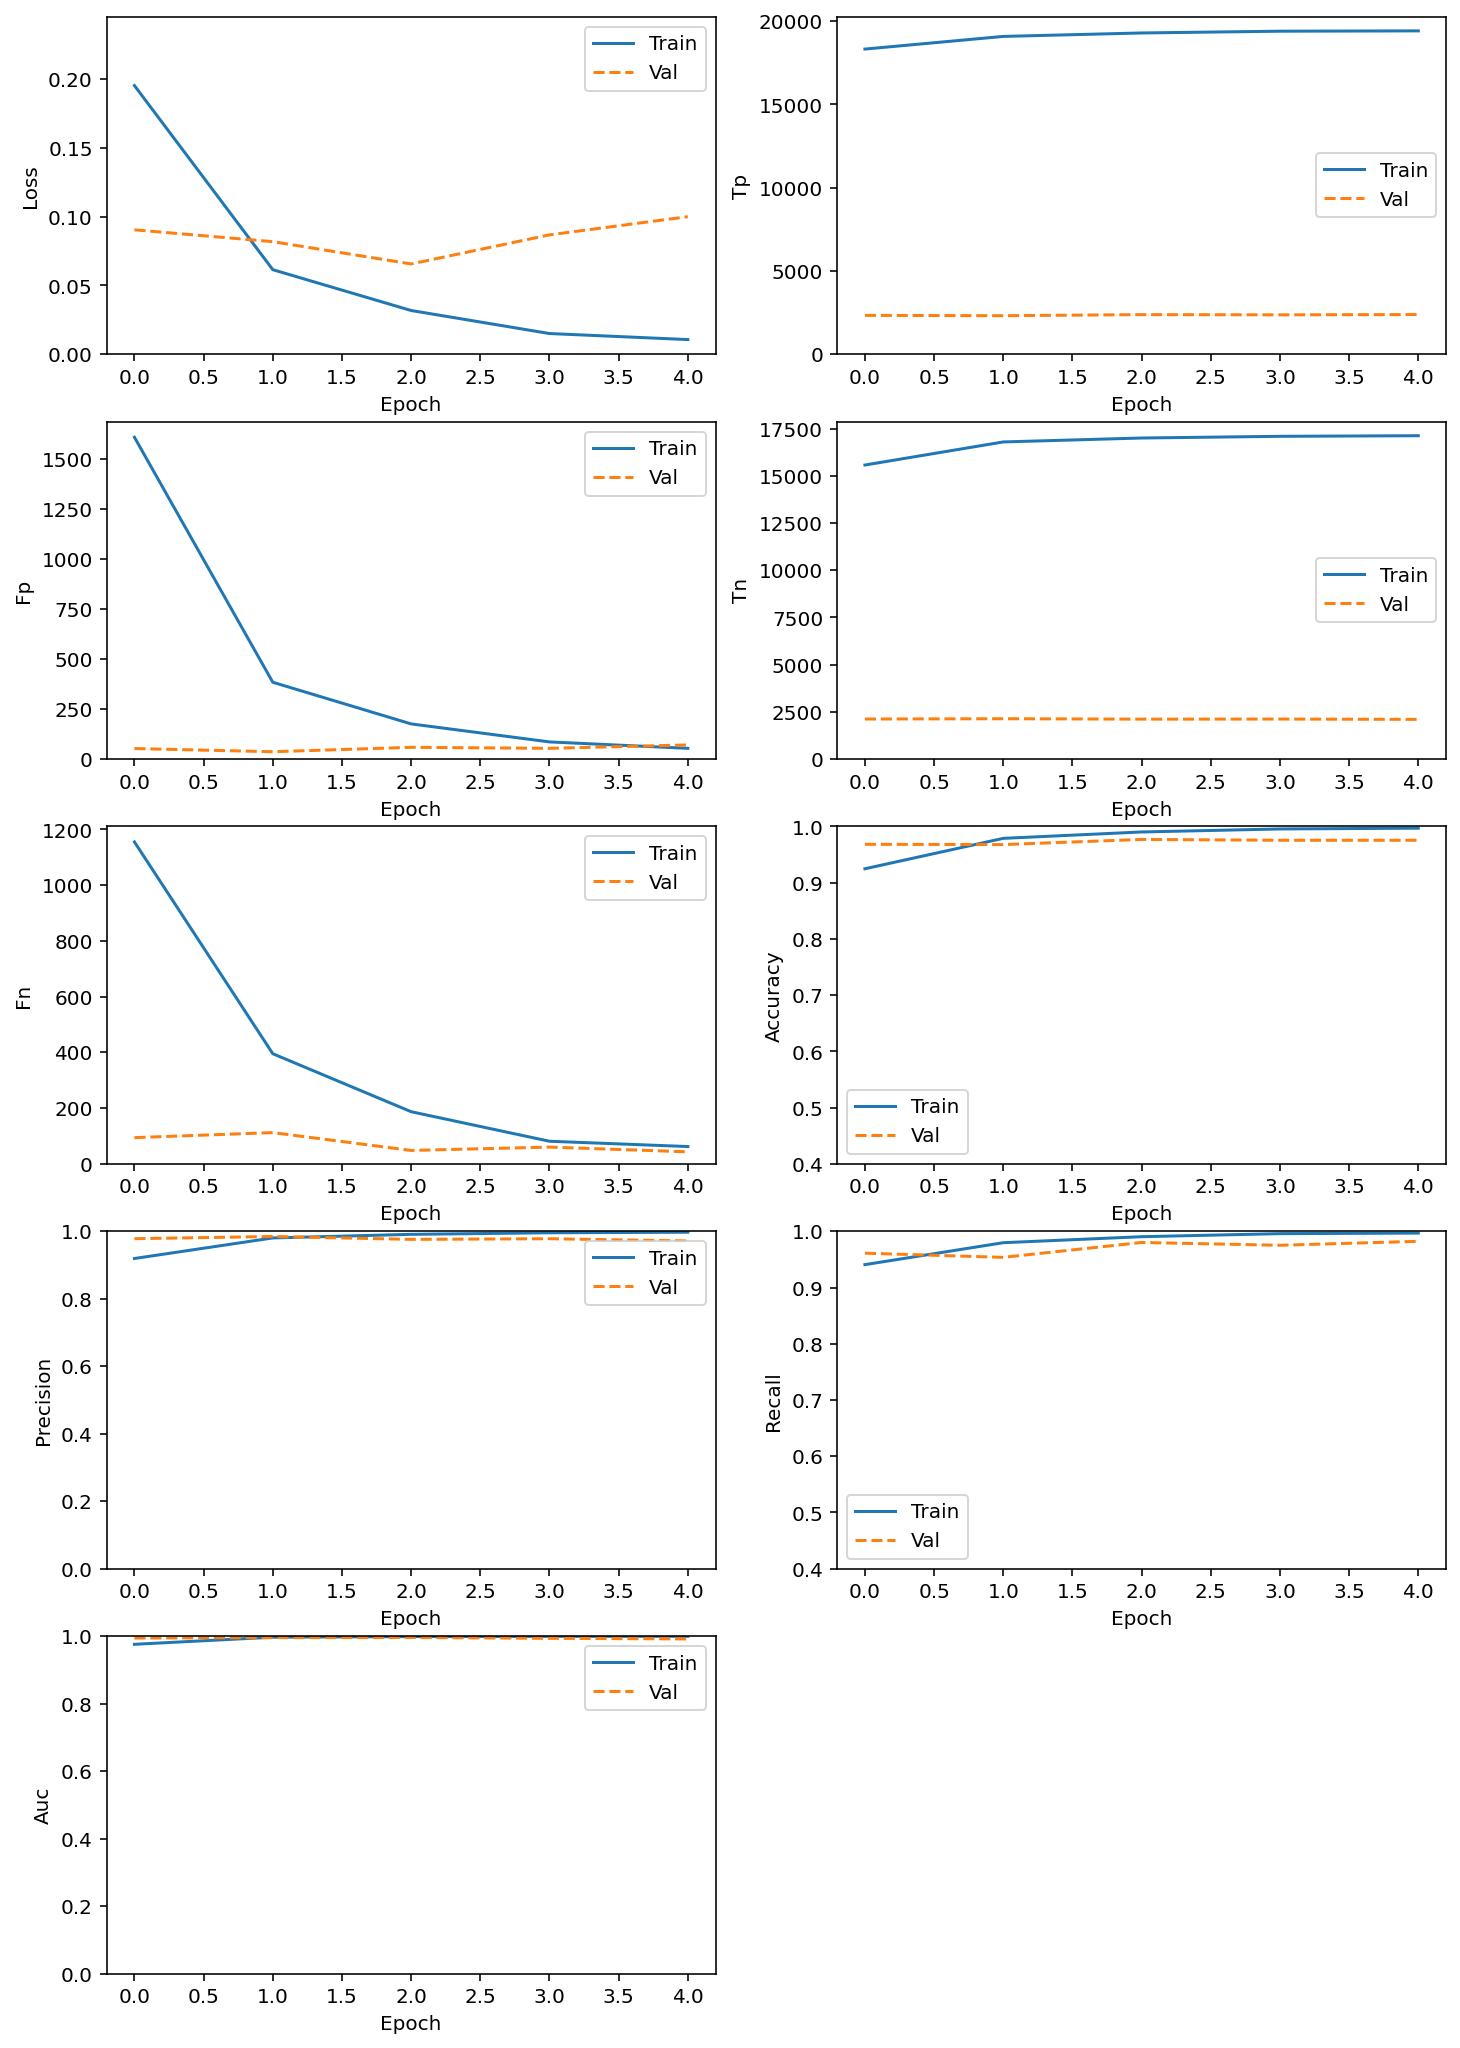

In [ ]:
# Cross Validation Classification Accuracy
  
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)
  
def plot_metrics(history):
	metrics = [
		"loss",
		"tp", "fp", "tn", "fn",
		"accuracy",
		"precision", "recall",
		"auc",
	]
	for n, metric in  enumerate(metrics):
		name = metric.replace("_", " ").capitalize()
		plt.subplot(5, 2, n + 1)
		plt.plot(
			history.epoch,
			history.history[metric],
			color=colors[0],
			label="Train",
		)
		plt.plot(
			history.epoch,
			history.history["val_" + metric],
			color=colors[1],
			linestyle="--",
			label="Val",
		)
		plt.xlabel("Epoch")
		plt.ylabel(name)
		if metric == "loss":
			plt.ylim([0, plt.ylim()[1] * 1.2])
		elif metric == "accuracy":
			plt.ylim([0.4, 1])
		elif metric == "fn":
			plt.ylim([0, plt.ylim()[1]])
		elif metric == "fp":
			plt.ylim([0, plt.ylim()[1]])
		elif metric == "tn":
			plt.ylim([0, plt.ylim()[1]])
		elif metric == "tp":
			plt.ylim([0, plt.ylim()[1]])
		elif metric == "precision":
			plt.ylim([0, 1])
		elif metric == "recall":
			plt.ylim([0.4, 1])
		else:
			plt.ylim([0, 1])
		  
		plt.legend()
  
plot_metrics(history)